In [1]:
using Statistics, LinearAlgebra, JUDI, SlimOptim, PyPlot, ImageFiltering, SegyIO, Pkg

┌ Info: Initializing openacc/openmp offloading
└ @ JUDI /home/geopc3/.julia/packages/JUDI/owInM/src/JUDI.jl:169


In [2]:
versioninfo()

Julia Version 1.9.2
Commit e4ee485e909 (2023-07-05 09:39 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 12 × AMD Ryzen 5 7600X 6-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver3)
  Threads: 1 on 12 virtual cores
Environment:
  JULIA_NUM_THREADS = 


In [3]:
run(`nvidia-smi`)

Thu Jul  6 17:21:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.51.01              Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti      On | 00000000:01:00.0  On |                  N/A |
| 56%   53C    P2               85W / 265W|   2002MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Process(`nvidia-smi`, ProcessExited(0))

In [4]:
Pkg.status()

Status `~/.julia/environments/v1.9/Project.toml`
  [f67ccb44] HDF5 v0.16.15
  [7073ff75] IJulia v1.24.2
  [6a3955dd] ImageFiltering v0.7.5
  [4138dd39] JLD v0.13.3
  [033835bb] JLD2 v0.4.31
  [f3b833dc] JUDI v3.3.5
  [32113eaa] PkgBenchmark v0.2.12
  [d330b81b] PyPlot v2.11.1
  [157a0f19] SegyIO v0.8.3
  [335f7d24] SetIntersectionProjection v0.2.4
  [e4c7bc62] SlimOptim v0.2.3


In [5]:
n = (101, 101)  # Number of grid point (nx, nz)
d = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
o = (0., 0.);  # What is the location of the top left corner. This is necessary to define
# velocities
v = 1.5f0 * ones(Float32, n)
v[:, 31:66] .= 1.5f0 + 0.5f0
v[:, 66:end] .= 1.5f0 + 1.5f0
v[41:61, 36:56] .= 1.5f0 + 1.0f0;

# Create initial model and smooth the boundaries
v0 = imfilter(v, Kernel.gaussian((5,5)));

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m0 - m);

# Setup model structure
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0);

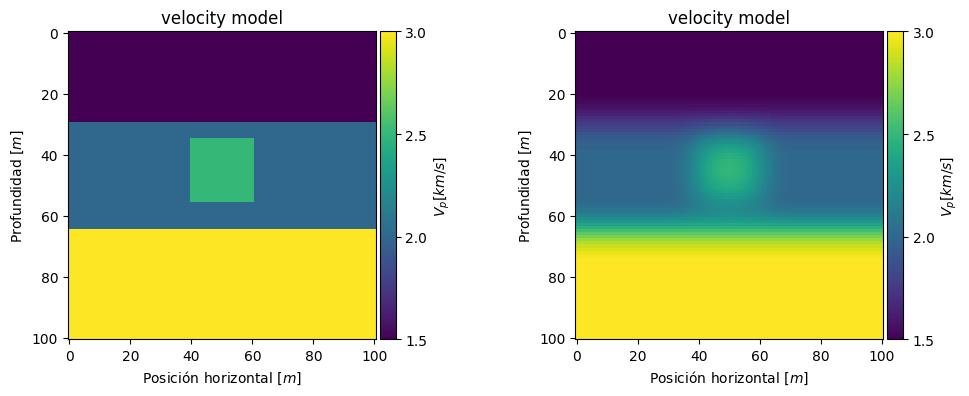

In [6]:
fig = figure(figsize=(12,4))
subplot(121)
im = imshow(v')
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p[km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("velocity model")
subplot(122)
im = imshow(v0')
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p[km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("velocity model")
display(fig)

In [7]:
# sources
nsrc = 21
# receivers
nxrec = 101
xrec = range(0f0, stop=(n[1]-1)*d[1], length=nxrec)
yrec = 0f0
zrec = range(30f0, stop=30f0, length=nxrec)

timeD = 1000f0
dtD = 2f0

recGeometry = Geometry(xrec, yrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

xsrc = convertToCell(range(0f0, stop=(n[1]-1)*d[1], length=nsrc))
ysrc = convertToCell(range(0f0, stop=0f0, length=nsrc))
zsrc = convertToCell(range(30f0, stop=30f0, length=nsrc))

srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtD, t=timeD)

f0 = 0.004f0     # kHz 4Hz
wavelet = ricker_wavelet(timeD, dtD, f0)
q = judiVector(srcGeometry, wavelet)

opt = Options(optimal_checkpointing = true)    # set to false to disable optimal checkpointing
Pr = judiProjection(recGeometry)
F = judiModeling(model; options=opt)
F0 = judiModeling(model0; options=opt)
Ps = judiProjection(srcGeometry)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)


In [8]:
d_obs = Pr*F*adjoint(Ps)*q

Building forward operator
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s
Operator `forward` ran in 0.12 s


judiVector{Float32, Matrix{Float32}} with 21 sources


In [9]:
dm = vec(model.m - model0.m);

In [10]:
dD = J*dm

MethodError: MethodError: no method matching process_input_data(::judiJacobian{Float32, :born, judiDataSourceModeling{Float32, :forward}}, ::Base.ReshapedArray{Float32, 1, PhysicalParameter{Float32, 2}, Tuple{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}}})

Closest candidates are:
  process_input_data(::judiJacobian{D, :born, FT}, !Matched::Union{PhysicalParameter{D}, Vector{D}}) where {D<:Number, FT}
   @ JUDI ~/.julia/packages/JUDI/owInM/src/TimeModeling/LinearOperators/operators.jl:196
  process_input_data(::judiJacobian{D, :born, FT}, !Matched::DenseArray) where {D<:Number, FT}
   @ JUDI ~/.julia/packages/JUDI/owInM/src/TimeModeling/LinearOperators/operators.jl:197
  process_input_data(::JUDI.judiPropagator{T}, !Matched::JUDI.judiMultiSourceVector{T}) where T
   @ JUDI ~/.julia/packages/JUDI/owInM/src/TimeModeling/LinearOperators/operators.jl:190
